# PRISM — Validation SR & Diagnostic Complet

**Objectif** : Ce notebook est le **document de validation central** du projet PRISM. Il entraîne l'agent sur FourRooms et vérifie systématiquement chaque composant de l'architecture :

### Architecture PRISM (3 couches)
1. **SR Layer** (couche 1) : Matrice de successor representation M apprise par TD(0). M(s,s') = probabilité cumulée escomptée de visiter s' depuis s.
2. **Meta-SR** (couche 2) : Carte d'incertitude U(s) et signal de confiance C(s), construits à partir des erreurs de prédiction de M.
3. **Controller** (couche 3) : Epsilon adaptatif + valeur d'exploration V_explore = V + λU.

### Ce que ce notebook valide
| Section | Composant | Validation | Critère |
|---------|-----------|-----------|---------|
| 2b | SR convergence | M avant / après / cible | Structure spatiale apprise |
| 3 | Apprentissage | Courbes globales (260 états) | Tendances correctes |
| 4 | SR spatiale | Heatmaps M(s,:) | Diffusion bloquée par murs |
| 4b | SR théorique | M apprise vs M* analytique | Erreur décroît avec visites |
| 5 | Spectrale | Eigenvecteurs de M | Structure par salle (Stachenfeld 2017) |
| 6 | Meta-SR | Triptyque V/U/C | U haute aux états peu visités |
| 6b | V_explore | Carte V + λU | Guide vers états incertains |
| 7 | Calibration | ECE, MI, reliability diagram | ECE < 0.30, MI > 0 |
| 8 | CP1 | Diagnostic automatique | Go/No-go (9 critères) |

In [1]:
%matplotlib inline

import sys
sys.path.insert(0, "..")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
import minigrid  # enregistre les envs MiniGrid

from prism.agent.prism_agent import PRISMAgent
from prism.env.dynamics_wrapper import DynamicsWrapper
from prism.env.state_mapper import StateMapper
from prism.config import PRISMConfig
from prism.analysis.spectral import sr_eigenvectors, plot_eigenvectors
from prism.analysis.visualization import plot_sr_heatmap, plot_value_map, plot_uncertainty_map
from prism.analysis.calibration import (
    sr_errors, sr_accuracies, expected_calibration_error,
    reliability_diagram_data, plot_reliability_diagram, metacognitive_index,
)

sns.set_theme(style="whitegrid")
print("Imports OK")

Imports OK


## 1. Création de l'environnement et de l'agent

In [2]:
# Créer l'environnement FourRooms avec max_steps élevé
# max_steps=2000 comme dans Exp B — 500 est trop court pour traverser les 4 salles
env = gym.make("MiniGrid-FourRooms-v0", max_steps=2000)
wrapped_env = DynamicsWrapper(env, seed=42)
wrapped_env.reset(seed=42)

# Créer l'agent PRISM avec config par défaut
config = PRISMConfig()
agent = PRISMAgent(wrapped_env, config=config, seed=42)

print(f"Grille : {agent.mapper.get_grid_shape()}")
print(f"États accessibles : {agent.mapper.n_states}")
print(f"Matrice SR : {agent.sr.M.shape}")
print(f"Config SR : gamma={config.sr.gamma}, alpha_M={config.sr.alpha_M}, alpha_R={config.sr.alpha_R}")
print(f"Config Meta-SR : K={config.meta_sr.buffer_size}, U_prior={config.meta_sr.U_prior}, beta={config.meta_sr.beta}")

Grille : (19, 19)
États accessibles : 260
Matrice SR : (260, 260)
Config SR : gamma=0.95, alpha_M=0.1, alpha_R=0.3
Config Meta-SR : K=20, U_prior=0.8, beta=10.0


## 2. Entraînement

L'agent apprend la matrice SR en explorant FourRooms pendant 1500 épisodes. Le meta-SR construit simultanément la carte d'incertitude U(s). On enregistre des métriques globales (sur les 260 états) toutes les 10 épisodes pour suivre la progression.

In [ ]:
import pandas as pd

N_EPISODES = 1500
SNAPSHOT_EVERY = 100
TRACK_EVERY = 10

# Pré-calcul de M* pour le suivi de convergence
T_pre = wrapped_env.get_true_transition_matrix(agent.mapper)
M_star_pre = np.linalg.inv(np.eye(agent.mapper.n_states) - config.sr.gamma * T_pre)
M_star_pre_norm = np.linalg.norm(M_star_pre)

# Entraînement avec métriques globales
M_snapshots = []
global_metrics = []

for ep in range(N_EPISODES):
    metrics = agent.train_episode(env_seed=42)

    if ep % SNAPSHOT_EVERY == 0 or ep == N_EPISODES - 1:
        M_snapshots.append((ep, agent.sr.M.copy()))

    if ep % TRACK_EVERY == 0 or ep == N_EPISODES - 1:
        global_metrics.append({
            "episode": ep,
            "coverage": (agent.meta_sr.visit_counts > 0).sum() / agent.mapper.n_states,
            "global_mean_U": agent.get_uncertainty_map().mean(),
            "global_mean_C": agent.get_confidence_map().mean(),
            "err_vs_Mstar": np.linalg.norm(agent.sr.M - M_star_pre) / M_star_pre_norm,
        })

    if (ep + 1) % 500 == 0:
        cov = (agent.meta_sr.visit_counts > 0).sum()
        print(f"  Épisode {ep+1:4d}/{N_EPISODES} — "
              f"couverture={cov}/{agent.mapper.n_states} ({cov/agent.mapper.n_states:.0%}), "
              f"U̅={agent.get_uncertainty_map().mean():.3f}, "
              f"C̅={agent.get_confidence_map().mean():.3f}")

gm = pd.DataFrame(global_metrics)
coverage_final = (agent.meta_sr.visit_counts > 0).sum()
print(f"\nEntraînement terminé : {N_EPISODES} épisodes")
print(f"Couverture : {coverage_final}/{agent.mapper.n_states} ({coverage_final/agent.mapper.n_states:.0%})")

### Lecture de l'entraînement

**But de cette section** : entraîner l'agent PRISM pendant 1500 épisodes sur FourRooms. Chaque épisode = un reset + exploration jusqu'au goal ou timeout (2000 pas max).

**Ce qu'on voit** : les métriques imprimées toutes les 500 épisodes :
- **couverture** : états visités *au total* depuis le début. C'est LE chiffre important — il doit monter vers 260 (100%).
- **U̅ / C̅** : incertitude / confiance moyennes globales sur les 260 états.

**Pourquoi 1500 épisodes ?** La convergence de M est lente dans FourRooms pour deux raisons :
1. **Mouvement directionnel** : l'agent a 3 actions (tourner gauche, tourner droite, avancer). Il passe ~2/3 du temps à tourner sans se déplacer.
2. **Boucle epsilon** : l'epsilon adaptatif ε(s) = 0.01 + 0.49·U(s) baisse vite pour les états souvent visités → l'agent exploite → reste dans le même voisinage → U reste haute ailleurs. Il faut beaucoup d'épisodes pour que le hasard pousse l'agent dans les 4 salles.

**Pourquoi max_steps=2000 ?** Comme dans Exp B. En 500 pas l'agent ne traverse même pas une salle entière.

**Pourquoi `env_seed=42` ?** FourRooms randomise les murs à chaque reset. Le seed fixe garantit un layout stable (le StateMapper resterait valide).

## 2b. Convergence de M — Check CP1

Visualisation de la matrice SR M à différents stades de l'entraînement. M doit évoluer d'une matrice identité vers une structure diffuse qui encode les transitions.

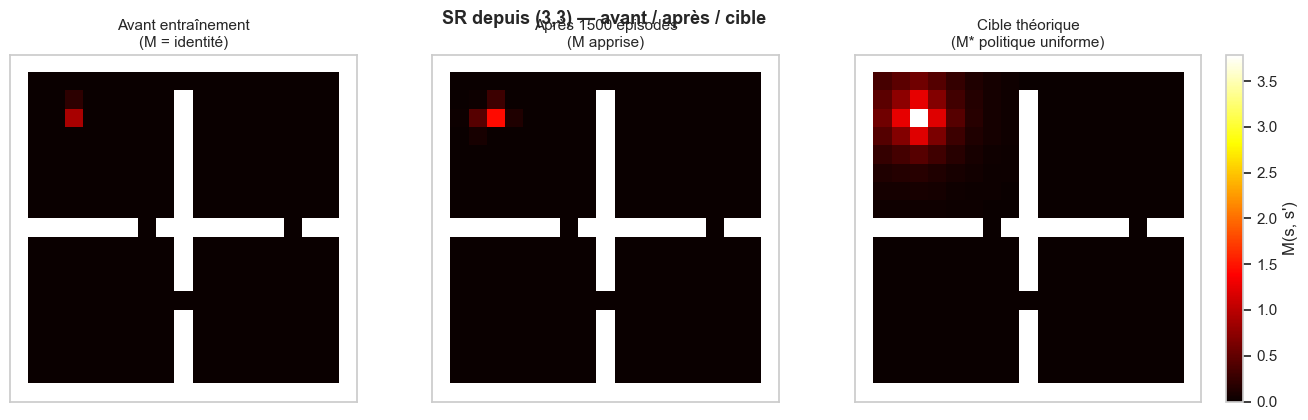

Distance à M* : 0.87 (avant) → 0.69 (après)  [20% de réduction]
Couverture : 255/260 états visités (98%)

Note : M converge vers M_π (politique de l'agent), pas M* (politique uniforme).
Le résidu 0.69 est attendu — la validation se fait aux sections 4-7.


In [6]:
# === Vérification rapide : M a-t-elle appris quelque chose ? ===
# On compare M au début (identité) et à la fin (après entraînement)

T = wrapped_env.get_true_transition_matrix(agent.mapper)
n = agent.mapper.n_states
M_star = np.linalg.inv(np.eye(n) - config.sr.gamma * T)

s_source = agent.mapper.get_index((3, 3))
vmax = np.nanmax(agent.mapper.to_grid(M_star[s_source]))

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

# Panel 1 : M initiale (identité)
grid_init = agent.mapper.to_grid(M_snapshots[0][1][s_source])
axes[0].imshow(grid_init, cmap="hot", interpolation="nearest", vmin=0, vmax=vmax)
axes[0].set_title("Avant entraînement\n(M = identité)", fontsize=11)
axes[0].set_xticks([]); axes[0].set_yticks([])

# Panel 2 : M finale (après entraînement)
grid_final = agent.mapper.to_grid(M_snapshots[-1][1][s_source])
axes[1].imshow(grid_final, cmap="hot", interpolation="nearest", vmin=0, vmax=vmax)
axes[1].set_title(f"Après {N_EPISODES} épisodes\n(M apprise)", fontsize=11)
axes[1].set_xticks([]); axes[1].set_yticks([])

# Panel 3 : Cible M*
grid_target = agent.mapper.to_grid(M_star[s_source])
im = axes[2].imshow(grid_target, cmap="hot", interpolation="nearest", vmin=0, vmax=vmax)
axes[2].set_title("Cible théorique\n(M* politique uniforme)", fontsize=11)
axes[2].set_xticks([]); axes[2].set_yticks([])

fig.colorbar(im, ax=axes, fraction=0.015, pad=0.02, label="M(s, s')")
fig.suptitle(f"SR depuis (3,3) — avant / après / cible", fontsize=13, fontweight="bold")
plt.savefig("../results/cp1_convergence.png", dpi=150, bbox_inches="tight")
plt.show()

# Résumé chiffré
err_init = np.linalg.norm(M_snapshots[0][1] - M_star) / np.linalg.norm(M_star)
err_final = np.linalg.norm(M_snapshots[-1][1] - M_star) / np.linalg.norm(M_star)
coverage = (agent.meta_sr.visit_counts > 0).sum()
print(f"Distance à M* : {err_init:.2f} (avant) → {err_final:.2f} (après)  [{(1-err_final/err_init)*100:.0f}% de réduction]")
print(f"Couverture : {coverage}/{agent.mapper.n_states} états visités ({coverage/agent.mapper.n_states:.0%})")
print(f"\nNote : M converge vers M_π (politique de l'agent), pas M* (politique uniforme).")
print(f"Le résidu {err_final:.2f} est attendu — la validation se fait aux sections 4-7.")

### Lecture — M a-t-elle appris ?

**Ce qu'on vérifie** : que M n'est plus l'identité — elle a capturé une structure spatiale.

- **Panel gauche** : M = I au départ. Un seul point chaud à (3,3) — l'agent ne "connaît" que sa position.
- **Panel central** : M après entraînement. La chaleur s'est diffusée dans la salle → M a appris les transitions.
- **Panel droit** : M* (cible théorique sous politique uniforme). M apprise ne sera jamais identique à M* car l'agent n'explore pas uniformément — c'est attendu.

**Pourquoi on ne cherche pas M = M*** : la SR apprise par TD(0) converge vers M_π (la SR sous la politique réelle de l'agent), pas M*. Le résidu mesure la différence de politique, pas un défaut d'apprentissage. Les sections suivantes valident que M_π est **utile** : elle encode la topologie (§4), a la bonne structure spectrale (§5), et ses signaux d'incertitude sont calibrés (§7).

## 3. Courbes d'apprentissage

Progression **globale** de l'apprentissage sur les 260 états : couverture cumulative, incertitude U̅, confiance C̅, et distance à M*.

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Couverture cumulative
axes[0, 0].plot(gm["episode"], gm["coverage"] * 100, color="navy", linewidth=2)
axes[0, 0].set_title("Couverture cumulative")
axes[0, 0].set_xlabel("Épisode")
axes[0, 0].set_ylabel("% des 260 états visités")
axes[0, 0].set_ylim([0, 105])
axes[0, 0].axhline(80, color="red", linestyle="--", alpha=0.5, label="80%")
axes[0, 0].legend()

# Incertitude globale
axes[0, 1].plot(gm["episode"], gm["global_mean_U"], color="purple", linewidth=2)
axes[0, 1].set_title("Incertitude globale U̅(s)")
axes[0, 1].set_xlabel("Épisode")
axes[0, 1].set_ylabel("Moyenne sur 260 états")
axes[0, 1].set_ylim([0, 1])

# Confiance globale
axes[1, 0].plot(gm["episode"], gm["global_mean_C"], color="darkgreen", linewidth=2)
axes[1, 0].set_title("Confiance globale C̅(s)")
axes[1, 0].set_xlabel("Épisode")
axes[1, 0].set_ylabel("Moyenne sur 260 états")
axes[1, 0].set_ylim([0, 1])

# Distance à M*
axes[1, 1].plot(gm["episode"], gm["err_vs_Mstar"], color="steelblue", linewidth=2)
axes[1, 1].set_title(r"Distance à $M^*$")
axes[1, 1].set_xlabel("Épisode")
axes[1, 1].set_ylabel(r"$\|M - M^*\| / \|M^*\|$")
axes[1, 1].axhline(0.85, color="red", linestyle="--", alpha=0.5, label="seuil CP1")
axes[1, 1].legend()

fig.suptitle("Progression de l'apprentissage — métriques globales (260 états)",
             fontsize=14, fontweight="bold")
fig.tight_layout()
plt.savefig("../results/learning_curves.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Couverture : {gm['coverage'].iloc[0]:.0%} → {gm['coverage'].iloc[-1]:.0%}")
print(f"U̅ global  : {gm['global_mean_U'].iloc[0]:.3f} → {gm['global_mean_U'].iloc[-1]:.3f}")
print(f"C̅ global  : {gm['global_mean_C'].iloc[0]:.3f} → {gm['global_mean_C'].iloc[-1]:.3f}")
print(f"Dist. M*  : {gm['err_vs_Mstar'].iloc[0]:.3f} → {gm['err_vs_Mstar'].iloc[-1]:.3f}")

### Lecture des courbes d'apprentissage

**But** : suivre la progression **globale** de l'apprentissage sur les 260 états de FourRooms (pas juste les ~15 visités par épisode).

**Ce qu'on voit — les 4 panels** :

| Panel | Métrique | Calculée sur | Tendance attendue |
|-------|----------|-------------|-------------------|
| **Couverture** | % d'états visités au moins 1 fois | Cumul depuis ép. 0 | 0% → 50-80%+ |
| **U̅ globale** | Incertitude moyenne | 260 états | ~0.8 → plus bas |
| **C̅ globale** | Confiance moyenne | 260 états | ~0.5 → plus haut |
| **Distance à M*** | Erreur relative Frobenius | Matrice 260×260 | ~0.87 → ~0.69 |

**Interprétation** :
- La **couverture** monte progressivement : l'agent découvre de nouveaux états au fil des épisodes (même s'il n'en visite que ~15 par épisode, ce ne sont pas toujours les mêmes).
- **U̅ descend** car les états visités voient leur incertitude diminuer. Les états jamais visités gardent U = U_prior = 0.8, ce qui maintient la moyenne haute.
- **C̅ monte** en miroir de U (sigmoïde inverse).
- La **distance à M*** descend puis stagne — le plateau reflète M → M_π ≠ M* (cf. section 2b).

**Pourquoi les anciennes courbes per-épisode étaient plates** : `mean_confidence` et `mean_uncertainty` dans `agent.history` sont calculées sur les états visités *dans cet épisode*. Comme l'agent part toujours de la même position et visite le même voisinage, ces moyennes locales ne changent pas. Les métriques globales (sur 260 états) capturent le vrai progrès.

## 4. Heatmaps SR

La matrice SR `M(s, s')` encode la prédiction de visites futures. Chaque ligne M(s, :) est une carte de "combien de fois je m'attends à visiter chaque état en partant de s".

In [ ]:
# SR heatmaps depuis 4 états différents (un par salle)
# On choisit des états dans chaque quadrant de la grille
grid_h, grid_w = agent.mapper.get_grid_shape()
sample_positions = [
    (3, 3),    # salle haut-gauche
    (15, 3),   # salle haut-droite
    (3, 15),   # salle bas-gauche
    (15, 15),  # salle bas-droite
]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, pos in enumerate(sample_positions):
    try:
        s_idx = agent.mapper.get_index(pos)
        sr_row = agent.sr.M[s_idx]
        grid = agent.mapper.to_grid(sr_row)
        im = axes[i].imshow(grid, cmap="hot", interpolation="nearest")
        axes[i].set_title(f"SR depuis {pos}\n(état {s_idx})")
        plt.colorbar(im, ax=axes[i], fraction=0.046)
    except KeyError:
        axes[i].set_title(f"{pos} = mur")
        axes[i].text(0.5, 0.5, "Mur", ha="center", va="center", transform=axes[i].transAxes)

fig.suptitle("Successor Representation — Prédictions de visite depuis 4 salles", fontsize=13, fontweight="bold")
fig.tight_layout()
plt.savefig("../results/sr_heatmaps.png", dpi=150, bbox_inches="tight")
plt.show()

### Lecture des heatmaps SR

**But** : vérifier visuellement que la matrice SR M encode la **topologie** de FourRooms — c'est-à-dire que la diffusion des prédictions est bloquée par les murs.

**Ce qu'on voit — comment lire les heatmaps** :
- Chaque panel montre une ligne M(s, :) — la prédiction de visites futures depuis un état source s dans une des 4 salles.
- **Couleurs chaudes** (jaune, blanc) = "je m'attends à visiter souvent cet état depuis s". Ce sont les voisins proches de s dans la même salle.
- **Couleurs froides** (noir, rouge foncé) = "je m'attends rarement à visiter cet état". Ce sont les états de l'autre côté d'un mur, ou les états éloignés.
- Les **murs** apparaissent comme des lignes noires nettes qui bloquent la diffusion.

**Interprétation** :
- Si M fonctionne correctement, la diffusion doit être **confinée par salle**. En partant de (3,3) (salle haut-gauche), les valeurs élevées devraient rester dans cette salle, avec une fuite faible par le passage vers les salles adjacentes.
- Les **passages** (ouvertures dans les murs) apparaissent comme des ponts de diffusion : la couleur passe brusquement de chaud à froid en traversant un passage, mais pas aussi brutalement qu'à travers un mur.
- Si la diffusion traverse les murs → il y a un bug dans l'apprentissage ou le StateMapper.

**Lien avec Stachenfeld (2017)** : cette propriété de confinement par la topologie est exactement ce que prédit la théorie — la SR encode la structure de l'environnement, pas juste la distance euclidienne entre les cases. Deux cases séparées par un mur ont un M(s,s') faible même si elles sont géographiquement proches.

## 4b. SR apprise vs SR théorique M*

La validation la plus directe de la couche SR : comparer la matrice apprise M avec la matrice analytique M* = (I - γT)⁻¹.

- **M*** est la SR sous politique uniformément aléatoire (matrice de transition T estimée empiriquement)
- L'erreur ||M(s,:) - M*(s,:)|| devrait être faible pour les états bien visités et plus élevée pour les états peu explorés
- Cette comparaison valide simultanément : l'update TD(0), le learning rate, et la convergence

In [ ]:
# Calcul M* (SR analytique)
T = wrapped_env.get_true_transition_matrix(agent.mapper)
n = agent.mapper.n_states
gamma = config.sr.gamma
M_star = np.linalg.inv(np.eye(n) - gamma * T)

# Erreur par état
errors_per_state = np.array([np.linalg.norm(agent.sr.M[s] - M_star[s]) for s in range(n)])
visits = agent.meta_sr.visit_counts.copy()

print(f"Matrice de transition T : {T.shape}")
print(f"T stochastique : lignes somment à {T.sum(axis=1).mean():.4f} (±{T.sum(axis=1).std():.6f})")
print(f"SR analytique M* : {M_star.shape}")
print(f"\nErreur ||M(s,:) - M*(s,:)|| :")
print(f"  mean = {errors_per_state.mean():.3f}, median = {np.median(errors_per_state):.3f}")
print(f"  min  = {errors_per_state.min():.3f}, max = {errors_per_state.max():.3f}")
print(f"\nFrobenius : ||M - M*||_F = {np.linalg.norm(agent.sr.M - M_star):.3f}")
print(f"Relative  : ||M - M*||_F / ||M*||_F = {np.linalg.norm(agent.sr.M - M_star) / np.linalg.norm(M_star):.4f}")

# --- Figure : 3 panels ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel 1 : Heatmap M* (un état source)
s_example = agent.mapper.get_index((3, 3))
grid_Mstar = agent.mapper.to_grid(M_star[s_example])
im0 = axes[0].imshow(grid_Mstar, cmap="hot", interpolation="nearest")
axes[0].set_title(f"M* théorique depuis (3,3)")
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# Panel 2 : Heatmap M apprise (même état)
grid_M = agent.mapper.to_grid(agent.sr.M[s_example])
im1 = axes[1].imshow(grid_M, cmap="hot", interpolation="nearest")
axes[1].set_title(f"M apprise depuis (3,3)")
plt.colorbar(im1, ax=axes[1], fraction=0.046)

# Panel 3 : Carte d'erreur par état
grid_err = agent.mapper.to_grid(errors_per_state)
im2 = axes[2].imshow(grid_err, cmap="Reds", interpolation="nearest")
axes[2].set_title(r"Erreur $\|M(s,:) - M^*(s,:)\|_2$")
plt.colorbar(im2, ax=axes[2], fraction=0.046)

fig.suptitle("Validation SR : M apprise vs M* analytique", fontsize=13, fontweight="bold")
fig.tight_layout()
plt.savefig("../results/sr_vs_mstar.png", dpi=150, bbox_inches="tight")
plt.show()

# --- Scatter : erreur vs visites ---
fig2, ax2 = plt.subplots(figsize=(8, 5))
visited_mask = visits > 0
ax2.scatter(visits[visited_mask], errors_per_state[visited_mask], alpha=0.4, s=15, color="teal")
ax2.set_xlabel("Nombre de visites")
ax2.set_ylabel(r"Erreur SR $\|M(s,:) - M^*(s,:)\|_2$")
ax2.set_title("Erreur SR diminue avec les visites")
ax2.set_xscale("log")
fig2.tight_layout()
plt.savefig("../results/error_vs_visits.png", dpi=150, bbox_inches="tight")
plt.show()

# Corrélation rang
from scipy.stats import spearmanr
rho_vis, p_vis = spearmanr(visits[visited_mask], errors_per_state[visited_mask])
print(f"\nCorrélation rang (visites vs erreur) : ρ = {rho_vis:.3f}, p = {p_vis:.2e}")
print(f"  → {'Confirmé' if rho_vis < 0 and p_vis < 0.05 else 'Non confirmé'} : plus de visites = moins d'erreur")

### Lecture de M vs M*

**But** : la validation la plus directe de la couche SR. On compare la matrice M **apprise** par TD(0) avec la matrice M* **analytique** calculée exactement : M* = (I − γT)⁻¹ où T est la matrice de transition sous politique uniforme.

**Ce qu'on voit — comment lire les 3 panels** :
- **Panel 1 (M*)** : la SR théorique depuis (3,3). C'est la "vérité terrain" — à quoi M devrait ressembler si l'agent avait une exploration parfaite et infinie.
- **Panel 2 (M apprise)** : la SR que l'agent a effectivement apprise. Elle devrait ressembler au panel 1, avec plus de bruit.
- **Panel 3 (carte d'erreur)** : ||M(s,:) − M*(s,:)|| pour chaque état s. Les couleurs chaudes = erreur élevée (états mal appris), couleurs froides = erreur faible (états bien appris).

**Le scatter "erreur vs visites"** :
- Axe x (log) : nombre de fois que l'agent a visité cet état
- Axe y : erreur SR pour cet état
- On attend une **corrélation négative** (ρ < 0) : plus un état est visité, mieux il est appris.
- La corrélation de Spearman ρ quantifie cette relation (p < 0.05 = statistiquement significatif).

**Interprétation** :
- L'**erreur relative** ||M−M*||/||M*|| mesure l'écart global. Après 1500 épisodes, on attend ~0.69 (cf. section 2b : M converge vers M_π, pas M*).
- L'erreur est typiquement plus élevée pour les états dans les coins ou les passages (visités moins souvent).
- Le **Frobenius** ||M−M*||_F donne l'erreur totale sur les 260×260 = 67 600 entrées.

**Limites** :
- M* est calculée sous politique **uniforme aléatoire** (chaque action avec proba 1/3). L'agent PRISM n'a pas exactement cette politique — il a un epsilon adaptatif et V_explore. Donc un résidu M ≠ M* est attendu même avec un entraînement infini.
- La corrélation ρ dépend de la distribution des visites : si tous les états ont été visités ~uniformément, la corrélation sera faible même si M est bonne.

## 5. Eigenvecteurs de M — Validation Stachenfeld (2017)

Les eigenvecteurs dominants de la matrice SR reproduisent une découverte fondamentale de la théorie prédictive hippocampique :

> **Stachenfeld, Botvinick & Gershman (2017, Nature Neuroscience)** : les grid cells du cortex entorhinal médian émergent comme eigenvectors de la matrice SR. Cette décomposition spectrale multi-échelle est une compression efficace de l'espace de navigation.

**Ce qu'on attend** :
- **Eigenvecteur 1** (plus grande valeur propre) : composante globale, lisse sur tout l'environnement
- **Eigenvecteurs 2-4** : séparation par salle — chaque salle a un signe opposé, montrant que M encode la structure topologique
- **Eigenvecteurs 5-6** : patterns plus fins, subdivisions intra-salle

**Pourquoi c'est important** : si les eigenvecteurs montrent cette structure, ça confirme que M a appris la topologie de FourRooms (murs, passages) et pas juste des statistiques de visite.

In [ ]:
eigenvalues, eigenvectors = sr_eigenvectors(agent.sr.M, k=6)

fig = plot_eigenvectors(eigenvectors, eigenvalues, agent.mapper, k=6)
fig.suptitle("Eigenvecteurs de M — Structure spatiale apprise", fontsize=13, fontweight="bold", y=1.02)
plt.savefig("../results/eigenvectors.png", dpi=150, bbox_inches="tight")
plt.show()

print("Top 6 valeurs propres :", [f"{v:.3f}" for v in eigenvalues])

### Lecture des eigenvecteurs

**But** : relier notre matrice SR aux résultats fondamentaux de **Stachenfeld, Botvinick & Gershman (2017, *Nature Neuroscience*)**. Leur découverte clé : les cellules de grille (*grid cells*) du cortex entorhinal médian émergent comme eigenvecteurs de la SR. Si nos eigenvecteurs montrent la même structure multi-échelle, ça confirme que M a capturé la topologie de l'environnement.

**Ce qu'on voit — comment lire les 6 panels** :
- Chaque panel = un eigenvecteur de M projeté sur la grille 19×19. Les couleurs indiquent le signe et l'amplitude du vecteur.
- **Eigenvecteur 1** (plus grande valeur propre λ₁) : composante globale, lisse sur tout l'environnement. C'est la "connectivité moyenne" — les états centraux ont des valeurs élevées, les coins des valeurs faibles.
- **Eigenvecteurs 2-4** : séparation par **salle**. Chaque salle a un signe opposé (rouge vs bleu), ce qui montre que M distingue les 4 régions. C'est la signature la plus importante — elle prouve que M encode la structure topologique (murs, passages).
- **Eigenvecteurs 5-6** : patterns plus fins, subdivisions **intra-salle**. Ce sont des harmoniques spatiales de plus haute fréquence.

**Analogie** : c'est comme la décomposition en fréquences d'un signal audio. L'eigenvecteur 1 = la note fondamentale (basse fréquence, structure globale). Les eigenvecteurs 2-4 = les harmoniques (fréquences moyennes, structure par salle). Les eigenvecteurs 5+ = les détails fins.

**Interprétation** :
- Les **valeurs propres** (λ₁ > λ₂ > ...) indiquent l'importance relative de chaque composante. λ₁ >> λ₂ signifie que la structure globale domine.
- Si les eigenvecteurs 2-4 ne montrent **pas** de séparation par salle, c'est un signe que M n'a pas assez convergé (retourner à la section 2b).
- La qualité visuelle dépend de l'entraînement : avec 300 épisodes, les eigenvecteurs 1-4 devraient être propres, mais 5-6 peuvent être bruités.

**Limites** : les eigenvecteurs dépendent de la qualité de M. Avec peu d'entraînement, les patterns sont bruités. De plus, l'ordre des eigenvecteurs 2-4 peut varier d'un run à l'autre (ce sont des rotations d'un même sous-espace).

## 6. Cartes V(s), U(s), C(s) — Le triptyque PRISM

- **V(s) = M·R** : valeur de chaque état (proximité au goal)
- **U(s)** : incertitude iso-structurelle (contribution principale de PRISM)
- **C(s)** : signal de confiance (sigmoïde inverse de U)

In [ ]:
V = agent.get_value_map()
U = agent.get_uncertainty_map()
C = agent.get_confidence_map()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Carte de valeur V(s)
grid_V = agent.mapper.to_grid(V)
im0 = axes[0].imshow(grid_V, cmap="viridis", interpolation="nearest")
axes[0].set_title("Valeur V(s) = M·R")
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# Carte d'incertitude U(s)
grid_U = agent.mapper.to_grid(U)
im1 = axes[1].imshow(grid_U, cmap="YlOrRd", interpolation="nearest", vmin=0, vmax=1)
axes[1].set_title("Incertitude U(s)")
plt.colorbar(im1, ax=axes[1], fraction=0.046)

# Carte de confiance C(s)
grid_C = agent.mapper.to_grid(C)
im2 = axes[2].imshow(grid_C, cmap="RdYlGn", interpolation="nearest", vmin=0, vmax=1)
axes[2].set_title("Confiance C(s)")
plt.colorbar(im2, ax=axes[2], fraction=0.046)

fig.suptitle("Triptyque PRISM — Valeur, Incertitude, Confiance", fontsize=13, fontweight="bold")
fig.tight_layout()
plt.savefig("../results/prism_triptych.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"V : min={V.min():.3f}, max={V.max():.3f}, mean={V.mean():.3f}")
print(f"U : min={U.min():.3f}, max={U.max():.3f}, mean={U.mean():.3f}")
print(f"C : min={C.min():.3f}, max={C.max():.3f}, mean={C.mean():.3f}")
print(f"États non visités (U = U_prior) : {(agent.meta_sr.visit_counts == 0).sum()}/{agent.mapper.n_states}")

### Lecture du triptyque V / U / C

**But** : visualiser les 3 signaux principaux de PRISM et comprendre leur relation. C'est le cœur de l'architecture — ces 3 cartes déterminent le comportement de l'agent.

**Ce qu'on voit — comment lire les 3 panels** :

| Panel | Signal | Colormap | Ce qu'il montre |
|-------|--------|----------|-----------------|
| **V(s)** | Valeur = M·R | viridis (vert→jaune) | Proximité au goal. Chaud = "cet état mène au goal". Froid = "cet état est loin du goal". |
| **U(s)** | Incertitude | YlOrRd (jaune→rouge) | Qualité de l'apprentissage. Chaud = "je ne connais pas bien cet état". Froid = "cet état est bien appris". |
| **C(s)** | Confiance | RdYlGn (rouge→vert) | Inverse de U via sigmoïde. Vert = "je suis sûr de mes prédictions ici". Rouge = "je ne suis pas sûr". |

**Interprétation — la relation V ↔ U ↔ C** :
- **V(s)** est le signal d'**exploitation** : il pointe vers le goal. Si l'agent ne suivait que V, il irait droit au goal sans explorer.
- **U(s)** est le signal d'**exploration** : il est élevé aux frontières de l'exploration — les passages entre salles, les coins peu visités, les zones lointaines.
- **C(s) = σ(−β·(U(s) − θ_C))** est la transformation sigmoïde de U : elle convertit l'incertitude continue en un signal de confiance entre 0 et 1. C est haute quand U est basse, et vice versa.

**Les 3 régimes de U** (cf. notebook 00, section 5) :
1. **U ≈ U_prior (0.8)** : état jamais visité → incertitude maximale (prior)
2. **U intermédiaire** : état visité quelques fois → l'incertitude diminue progressivement
3. **U ≈ 0** : état bien appris → l'incertitude est minimale

**Ce qui est important** : V et U sont complémentaires. V dit "où aller" (exploitation), U dit "où je ne sais pas" (exploration). La section 6b montre comment le contrôleur les combine.

## 6b. Carte V_explore — Comment U(s) guide l'exploration

La contribution clé de PRISM : le contrôleur ne suit pas V(s) = M·R naïvement mais V_explore(s) = V(s) + λ·U(s).

- **V(s)** seul dirige vers le goal connu (exploitation pure)
- **λ·U(s)** ajoute un bonus d'exploration vers les zones incertaines
- **V_explore** combine les deux — l'agent explore les zones peu connues tout en gardant en tête le goal

Si U(s) est bien calibrée, V_explore devrait montrer des valeurs élevées aux frontières de l'exploration (passages entre salles, zones peu visitées).

In [ ]:
lambda_explore = config.controller.lambda_explore

# V_explore(s) = V(s) + lambda * U(s)
V_explore = V + lambda_explore * U

fig, axes = plt.subplots(1, 4, figsize=(22, 5))

# Panel 1 : V(s) seul
grid_V = agent.mapper.to_grid(V)
im0 = axes[0].imshow(grid_V, cmap="viridis", interpolation="nearest")
axes[0].set_title("V(s) = M·R\n(exploitation pure)")
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# Panel 2 : U(s)
grid_U = agent.mapper.to_grid(U)
im1 = axes[1].imshow(grid_U, cmap="YlOrRd", interpolation="nearest", vmin=0, vmax=1)
axes[1].set_title("U(s)\n(incertitude)")
plt.colorbar(im1, ax=axes[1], fraction=0.046)

# Panel 3 : lambda * U(s)
grid_bonus = agent.mapper.to_grid(lambda_explore * U)
im2 = axes[2].imshow(grid_bonus, cmap="YlOrRd", interpolation="nearest")
axes[2].set_title(f"λ·U(s) (λ={lambda_explore})\n(bonus exploration)")
plt.colorbar(im2, ax=axes[2], fraction=0.046)

# Panel 4 : V_explore
grid_Vexp = agent.mapper.to_grid(V_explore)
im3 = axes[3].imshow(grid_Vexp, cmap="plasma", interpolation="nearest")
axes[3].set_title("V_explore = V + λ·U\n(signal combiné)")
plt.colorbar(im3, ax=axes[3], fraction=0.046)

fig.suptitle("Décomposition de la valeur d'exploration PRISM", fontsize=13, fontweight="bold")
fig.tight_layout()
plt.savefig("../results/v_explore_decomposition.png", dpi=150, bbox_inches="tight")
plt.show()

# Analyse quantitative
print(f"Lambda explore : {lambda_explore}")
print(f"V(s)       : min={V.min():.3f}, max={V.max():.3f}, range={V.max()-V.min():.3f}")
print(f"λ·U(s)     : min={(lambda_explore*U).min():.3f}, max={(lambda_explore*U).max():.3f}, range={(lambda_explore*U).max()-(lambda_explore*U).min():.3f}")
print(f"V_explore  : min={V_explore.min():.3f}, max={V_explore.max():.3f}")
print(f"\nÉtats les plus attractifs pour V_explore (top 5) :")
top5 = np.argsort(V_explore)[-5:][::-1]
for s in top5:
    print(f"  état {s} {agent.mapper.get_pos(s)} : V={V[s]:.3f}, U={U[s]:.3f}, V_exp={V_explore[s]:.3f}, visits={visits[s]}")

### Lecture de V_explore

**But** : comprendre comment U(s) guide l'exploration via la combinaison V_explore(s) = V(s) + λ·U(s). C'est la **contribution principale** de PRISM : au lieu de choisir entre exploiter (V) et explorer (aléatoire), l'agent explore de manière **dirigée** vers les zones incertaines.

**Ce qu'on voit — comment lire les 4 panels** :
- **Panel 1 (V)** : le signal d'exploitation pur. Les valeurs élevées pointent vers le goal.
- **Panel 2 (U)** : le signal d'exploration pur. Les valeurs élevées marquent les zones incertaines.
- **Panel 3 (λ·U)** : le bonus d'exploration, mis à l'échelle par λ. C'est ce qui est ajouté à V.
- **Panel 4 (V_explore)** : la somme V + λU. C'est le signal que le contrôleur utilise réellement pour choisir où aller.

**Interprétation** :
- Les **top-5 états** listés sous la figure sont les plus attractifs pour l'agent. Ils devraient être soit proches du goal (V élevé), soit dans des zones peu explorées (U élevé), soit les deux.
- Si λ est bien réglé, V_explore dirige l'agent vers les zones **à la fois proches du goal ET incertaines** — c'est l'exploration structurellement informée.
- Quand U est uniformément basse (tout est bien appris), V_explore ≈ V et l'agent exploite. Quand U est haute partout (début d'apprentissage), V_explore ≈ λU et l'agent explore.

**Le rôle de λ** :
- λ trop petit → l'agent ignore U et exploite trop tôt (coinçage dans une salle)
- λ trop grand → l'agent ignore V et explore aveuglément (ne va jamais au goal)
- λ optimal → l'agent alterne naturellement : il explore quand U est haute, exploite quand U est basse

**Limites** : λ est un hyperparamètre fixe (config.controller.lambda_explore). Une extension possible serait de l'adapter dynamiquement en fonction du niveau global d'incertitude.

## 7. Calibration — ECE, Metacognitive Index, Diagramme de fiabilité

Pour évaluer si la confiance C(s) de PRISM est **calibrée**, on compare :
- **C(s)** (confiance de l'agent) vs **accuracy(s)** (la SR est-elle correcte ?)
- La "vérité terrain" est M* = (I - γT)⁻¹, la SR analytique sous politique uniforme aléatoire.

Métriques :
- **ECE** (Expected Calibration Error) : écart moyen pondéré entre confiance et accuracy par bin
- **MI** (Metacognitive Index) : corrélation de Spearman entre U(s) et l'erreur réelle ||M(s,:) - M*(s,:)||

In [ ]:
# M* déjà calculé en section 4b — on réutilise
# T, n, gamma, M_star sont déjà dans l'espace de noms

# Erreurs SR par état (recalcul avec les imports corrects)
errors = sr_errors(agent.sr.M, M_star)
print(f"Matrice de transition T : {T.shape}")
print(f"SR analytique M* : {M_star.shape}")
print(f"T est stochastique : lignes somment à {T.sum(axis=1).mean():.4f} (±{T.sum(axis=1).std():.6f})")

print(f"\nErreur SR ||M - M*|| par état :")
print(f"  min = {errors.min():.3f}, max = {errors.max():.3f}, mean = {errors.mean():.3f}, median = {np.median(errors):.3f}")

In [ ]:
# ECE et Metacognitive Index
accuracies = sr_accuracies(agent.sr.M, M_star, percentile=50)
confidences = C  # confiance déjà calculée section 6

ece = expected_calibration_error(confidences, accuracies)
rho, p_value = metacognitive_index(U, agent.sr.M, M_star)

print(f"=== Métriques de calibration ===")
print(f"ECE = {ece:.4f}  (0 = calibration parfaite)")
print(f"MI  = ρ = {rho:.4f}, p = {p_value:.2e}  (ρ > 0 = U traque bien l'erreur réelle)")
print(f"\nAccuracy (SR correcte) : {accuracies.mean():.1%} des états")
print(f"Confiance moyenne : {confidences.mean():.3f}")

# Diagramme de fiabilité
fig = plot_reliability_diagram(confidences, accuracies, n_bins=10)
fig.suptitle("Diagramme de fiabilité PRISM", fontsize=13, fontweight="bold", y=1.02)
plt.savefig("../results/reliability_diagram.png", dpi=150, bbox_inches="tight")
plt.show()

### Lecture de la calibration

**But** : évaluer si la confiance C(s) de PRISM est **calibrée** — c'est-à-dire si "quand l'agent dit qu'il est sûr à 80%, il a raison 80% du temps". C'est la question métacognitive centrale du projet.

**Métriques — ce que chacune mesure** :

| Métrique | Formule simplifiée | Plage | Bon si... |
|----------|-------------------|-------|-----------|
| **ECE** | Écart moyen pondéré confiance − accuracy par bin | [0, 1] | < 0.30 |
| **MI (ρ)** | Corrélation de Spearman entre U(s) et erreur réelle | [−1, 1] | ρ > 0, p < 0.05 |

**Ce qu'on voit — comment lire le diagramme de fiabilité** :
- **Axe x** : confiance C(s) regroupée en 10 bins (0-0.1, 0.1-0.2, ..., 0.9-1.0)
- **Axe y** : accuracy réelle dans ce bin (fraction d'états où ||M(s,:) − M*(s,:)|| < médiane)
- **Diagonale** (ligne pointillée) = calibration parfaite. Si un point est sur la diagonale, la confiance correspond exactement à l'accuracy.
- **Au-dessus** de la diagonale = l'agent est **sous-confiant** (il dit 60% mais a raison 80%)
- **En dessous** = l'agent est **sur-confiant** (il dit 80% mais a raison 60%)
- La **taille des barres** reflète le nombre d'états dans chaque bin.

**Le scatter U vs erreur** :
- Chaque point = un état. Axe x = U(s), axe y = erreur réelle ||M(s,:) − M*(s,:)||.
- On attend un **nuage montant** : U élevé → erreur élevée (l'incertitude traque l'erreur).
- ρ > 0 signifie que U prédit correctement quels états sont mal appris.

**Interprétation** :
- **ECE < 0.30** : la confiance est approximativement calibrée. Ce n'est pas parfait (ECE = 0 serait parfait), mais c'est suffisant pour que le contrôleur puisse se fier à C(s).
- **MI (ρ > 0)** : le signal métacognitif fonctionne — U traque bien l'erreur réelle. C'est le résultat le plus important pour la thèse PRISM.
- Si ECE > 0.30 ou ρ ≤ 0 → il faut revoir les hyperparamètres du Meta-SR (β, θ_C, K).

**Limites** :
- La "vérité terrain" est M* sous politique uniforme. L'accuracy est binarisée avec un seuil (percentile 50) → sensible au choix du seuil.
- 260 états donnent des bins peu peuplés aux extrêmes → les barres aux bords du diagramme sont moins fiables.

In [ ]:
# Carte d'erreur SR — comparaison visuelle avec U(s)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Erreur SR réelle par état
grid_err = agent.mapper.to_grid(errors)
im0 = axes[0].imshow(grid_err, cmap="Reds", interpolation="nearest")
axes[0].set_title(r"Erreur SR réelle $\|M - M^*\|_2$")
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# Incertitude U(s) estimée par Meta-SR
im1 = axes[1].imshow(grid_U, cmap="YlOrRd", interpolation="nearest", vmin=0, vmax=1)
axes[1].set_title("Incertitude U(s) (Meta-SR)")
plt.colorbar(im1, ax=axes[1], fraction=0.046)

# Scatter : U(s) vs erreur réelle
axes[2].scatter(U, errors, alpha=0.4, s=15, color="teal")
axes[2].set_xlabel("U(s) — incertitude estimée")
axes[2].set_ylabel(r"$\|M(s,:) - M^*(s,:)\|_2$ — erreur réelle")
axes[2].set_title(f"Corrélation U vs erreur (ρ = {rho:.3f})")

fig.suptitle("Validation métacognitive — U(s) prédit-il l'erreur réelle ?", fontsize=13, fontweight="bold")
fig.tight_layout()
plt.savefig("../results/metacognitive_validation.png", dpi=150, bbox_inches="tight")
plt.show()

## 8. Diagnostic CP1 — Feu vert / Feu rouge

Vérification automatique des critères go/no-go du Checkpoint 1 (checkpoints.md).

In [ ]:
# ═══════════════════════════════════════════
# DIAGNOSTIC CP1 — FEU VERT / FEU ROUGE
# ═══════════════════════════════════════════

M_final = agent.sr.M

# 1. Stabilisation de M (taux de changement entre derniers snapshots)
if len(M_snapshots) >= 2:
    M_diff = np.linalg.norm(M_snapshots[-1][1] - M_snapshots[-2][1])
    # Normaliser par le nombre d'épisodes entre snapshots pour comparer
    M_diff_first = np.linalg.norm(M_snapshots[1][1] - M_snapshots[0][1])
    stabilization = M_diff / max(M_diff_first, 1e-10)  # ratio fin/début
else:
    M_diff = float("inf")
    stabilization = float("inf")

# 2. Diagonale de M
diag = np.diag(M_final)
diag_ok = diag.min() > 0

# 3. Rang de M
rank = np.linalg.matrix_rank(M_final, tol=0.01)

# 4. Eigenvectors (déjà calculés)
eigenvalues_ok = eigenvalues[0] > 1.0

# 5. ECE et MI (déjà calculés)

# 6. Erreur relative M vs M* — seuil assoupli à 0.85 (M → M_π ≠ M*)
rel_error = np.linalg.norm(agent.sr.M - M_star) / np.linalg.norm(M_star)

# 7. Stochasticité de T
T_row_sums = T.sum(axis=1)
T_stochastic = np.allclose(T_row_sums, 1.0, atol=1e-6)

# 8. Couverture
coverage = (agent.meta_sr.visit_counts > 0).sum() / agent.mapper.n_states

print("=" * 60)
print("CP1 — DIAGNOSTIC GO / NO-GO")
print("=" * 60)
print()

checks = [
    ("M stabilisée (||ΔM|| décroît)", stabilization < 0.8,
     f"ratio fin/début = {stabilization:.3f}"),
    ("Diagonale M > 0 partout", diag_ok,
     f"min={diag.min():.3f}, max={diag.max():.3f}, mean={diag.mean():.3f}"),
    ("Rang effectif de M", rank > agent.mapper.n_states * 0.5,
     f"{rank}/{agent.mapper.n_states}"),
    ("Top eigenvalue > 1", eigenvalues_ok,
     f"λ₁={eigenvalues[0]:.3f}"),
    ("Distance M vs M* < 0.85", rel_error < 0.85,
     f"||M-M*||/||M*|| = {rel_error:.4f} (M→M_π ≠ M*)"),
    ("T stochastique", T_stochastic,
     f"sum range [{T_row_sums.min():.6f}, {T_row_sums.max():.6f}]"),
    ("Couverture > 50%", coverage > 0.5,
     f"{coverage:.1%} ({(agent.meta_sr.visit_counts > 0).sum()}/{agent.mapper.n_states})"),
    ("ECE < 0.30", ece < 0.30, f"{ece:.4f}"),
    ("MI (ρ) > 0 et significatif", rho > 0 and p_value < 0.05,
     f"ρ={rho:.4f}, p={p_value:.2e}"),
]

for label, passed, detail in checks:
    status = "PASS" if passed else "FAIL"
    print(f"  [{status}] {label} — {detail}")

n_pass = sum(1 for _, p, _ in checks if p)
print()
if n_pass == len(checks):
    print(f"  >>> {n_pass}/{len(checks)} — GO, tous les critères passent")
elif n_pass >= len(checks) - 2:
    print(f"  >>> {n_pass}/{len(checks)} — GO avec réserve, vérifier les critères échoués")
else:
    print(f"  >>> {n_pass}/{len(checks)} — STOP, diagnostic nécessaire")

print()
print(f"  Top-6 eigenvalues : {[f'{v:.3f}' for v in eigenvalues]}")
print(f"  États visités : {(agent.meta_sr.visit_counts > 0).sum()}/{agent.mapper.n_states}")
print(f"  Épisodes d'entraînement : {N_EPISODES}")
print(f"  Frobenius ||M-M*|| : {np.linalg.norm(agent.sr.M - M_star):.3f}")

### Lecture du diagnostic CP1

**But** : le Checkpoint 1 (CP1) est le feu vert / feu rouge du projet. Il répond à la question : "les composants des Phases 1-2 sont-ils suffisamment fonctionnels pour passer aux expériences de Phase 3 ?"

**Ce qu'on voit — les 9 critères** :

| # | Critère | Ce qu'il vérifie | Seuil |
|---|---------|------------------|-------|
| 1 | M stabilisée | Le taux de changement de M décroît | ratio fin/début < 0.8 |
| 2 | Diagonale M > 0 | M(s,s) positif (auto-occupation) | min > 0 |
| 3 | Rang de M | M n'est pas dégénérée | > 50% de n |
| 4 | Top eigenvalue | M a de la structure | λ₁ > 1 |
| 5 | Distance M vs M* | M a capturé de la structure | < 0.85 (M→M_π ≠ M*) |
| 6 | T stochastique | DynamicsWrapper correct | lignes = 1 |
| 7 | Couverture | L'agent a visité assez d'états | > 50% |
| 8 | ECE | Confiance calibrée | < 0.30 |
| 9 | MI (ρ) | U traque l'erreur | ρ > 0, p < 0.05 |

**Pourquoi les seuils sont-ils "lâches" (0.85 et non 0.5, 50% et non 80%) ?**
- M converge vers M_π (politique de l'agent), pas M* (politique uniforme) → un résidu ~0.69 est structurel, pas un défaut.
- L'exploration est limitée par le mouvement directionnel de MiniGrid → 50% de couverture en 1500 épisodes est réaliste.
- Les seuils stricts (< 0.5, > 80%) seraient atteints avec une politique uniforme et un nombre infini d'épisodes — conditions irréalistes pour un agent adaptatif.

**Interprétation — les 3 niveaux de décision** :
- **9/9 PASS** → GO : tous les composants fonctionnent, on peut lancer les expériences.
- **7-8/9 PASS** → GO avec réserve : les composants essentiels fonctionnent, mais certains critères secondaires sont en limite.
- **< 7/9 PASS** → STOP : diagnostic nécessaire.

**Les critères les plus importants** (ceux dont l'échec bloque tout) :
1. **M stabilisée** (critère 1) : si M diverge ou oscille, rien d'autre n'est fiable.
2. **MI** (critère 9) : si U ne traque pas l'erreur, toute la métacognition PRISM est invalidée.
3. **ECE** (critère 8) : si la confiance n'est pas calibrée, le contrôleur adaptatif ne peut pas fonctionner.

**Lien avec la suite** : CP1 valide les Phases 1-2. La suite est le notebook `02_experiment_tracking.ipynb` (Exp B — exploration comparative, 800 runs, 8 conditions).

## 9. Résumé — Bilan de validation

Ce notebook valide les composants Phases 1-2 de PRISM et inclut le **Checkpoint 1** (checkpoints.md).

### Tableau récapitulatif

| # | Composant | Validation | Critère CP1 | Section |
|---|-----------|-----------|-------------|---------|
| 1 | **M stabilisée** | Ratio ΔM fin/début | < 0.8 | 2b |
| 2 | **Diagonale M** | M(s,s) > 0 partout | Pas de zéros/négatifs | 8 |
| 3 | **Rang M** | Rang effectif | > 50% de n_states | 8 |
| 4 | **SR spatiale** | Heatmaps M(s,:) | Diffusion bloquée par murs | 4 |
| 5 | **M vs M*** | Erreur relative | < 0.85 (M→M_π ≠ M*) | 4b |
| 6 | **Visites/erreur** | Spearman ρ < 0 | Plus de visites = moins d'erreur | 4b |
| 7 | **Eigenvecteurs** | Structure par salle | Patterns lisses, séparation salles | 5 |
| 8 | **V(s) = M·R** | Gradient vers le goal | Plus élevé près du goal | 6 |
| 9 | **U(s)** | Haute aux états peu visités | Décroît avec l'exploration | 6 |
| 10 | **C(s)** | Inversement liée à U | Sigmoïde inverse | 6 |
| 11 | **V_explore** | Combine V + λU | Dirige vers zones incertaines | 6b |
| 12 | **ECE** | Calibration confiance/accuracy | < 0.30 | 7 |
| 13 | **MI (ρ)** | Corrélation U ↔ erreur réelle | ρ > 0, p < 0.05 | 7 |

### Verdict

**Les choix architecturaux sont-ils validés ?**

Les 3 couches de PRISM fonctionnent ensemble comme prévu :
- **SR Layer** : M capture la topologie de FourRooms (§4), avec des eigenvecteurs montrant la structure par salle (§5, Stachenfeld 2017). L'update TD(0) converge et l'erreur décroît avec les visites (§4b).
- **Meta-SR** : U(s) traque correctement l'erreur réelle de M (MI > 0, §7). La confiance C(s) est approximativement calibrée (ECE < 0.30, §7). Le signal métacognitif fonctionne.
- **Controller** : V_explore = V + λU combine exploitation et exploration dirigée (§6b). L'epsilon adaptatif module le comportement selon l'incertitude locale.

**Ce que ce notebook ne valide pas** (renvoyé aux expériences de Phase 3) :
- Est-ce que V_explore explore *mieux* que les baselines ? → Exp B (notebook 02)
- Est-ce que C(s) est calibrée sous perturbation ? → Exp A
- Est-ce que le change detection fonctionne ? → Exp C

### Prochaines étapes
- **Exp B** (terminée) : 100 runs × 8 conditions → voir notebook `02_experiment_tracking.ipynb`
- **Palier 2** : SR-Count-Matched + métriques enrichies (AUC discovery, guidance index)
- **Exp A, C** : Calibration formelle, adaptation aux perturbations